In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Flatten,Input
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras import backend as K
from keras.optimizers import Adam,RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ReduceLROnPlateau


In [4]:
def plt_dynamic(x,vy,ty,ax,label1='Validation_loss',label2='Train_loss'):
    ax.plot(x,vy,'b',label=label1)
    ax.plot(x,ty,'r',label=label2)
    plt.legend()
    plt.grid()
    fig.canvas.draw()

In [50]:
def preprocessing(path,images,y_label,flag=True):  
    for i in os.listdir(path):
        image_path=path+'/'+i
        image=cv2.imread(image_path,0)
        image=cv2.resize(image,(225,225),cv2.INTER_CUBIC)
        image=cv2.GaussianBlur(image,(5,5),cv2.BORDER_DEFAULT)
        images.append(image)
        if flag==True:
            y_label.append(0) 
        else:
            y_label.append(1)
    return images,y_label

In [6]:
def data(path,path_Pneumonia):
    images=[]
    y_label=[]
    images,y_label=preprocessing(path,images,y_label)
    images,y_label=preprocessing(path_Pneumonia,images,y_label,False)
    return images,y_label

In [51]:
path='../input/chest-xray-pneumonia/chest_xray/train/NORMAL'
pathp='../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
pathtest='../input/chest-xray-pneumonia/chest_xray/test/NORMAL'
pathptest='../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'
pathcv='../input/chest-xray-pneumonia/chest_xray/val/NORMAL/'
pathpcv='../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/'
x_train,y_train=data(path,pathp)
x_test,y_test=data(pathtest,pathptest)
x_cv,y_cv=data(pathcv,pathpcv)

In [52]:
x_train=np.array(x_train)
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)
x_cv=np.array(x_cv)
y_cv=np.array(y_cv)

In [55]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_cv.shape)
print(y_cv.shape)

(5216, 225, 225, 1)
(5216,)
(624, 225, 225, 1)
(624,)
(16, 225, 225, 1)
(16,)


In [53]:
img_rows,img_cols=225,225
if K.image_data_format() == 'channels_first':
    x_train= x_train.reshape(x_train.shape[0],1,img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    x_cv = x_cv.reshape(x_cv.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train= x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    x_cv = x_cv.reshape(x_cv.shape[0],img_rows, img_cols,1)
    input_shape = (img_rows, img_cols, 1)

In [41]:
x_train=x_train/255
x_test=x_test/255
x_cv=x_cv/255

In [58]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [66]:
def structure(activation='relu',dropout=0.3,kernel='glorot_uniform'):
    numclasses=1
    model=Sequential()
    model.add(Conv2D(32,kernel_size=(3,3),activation=activation,input_shape=input_shape,kernel_initializer=kernel))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(64,(3,3),activation=activation,kernel_initializer=kernel))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation=activation,kernel_initializer=kernel))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(256,(3,3),activation=activation,kernel_initializer=kernel))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3),activation=activation,kernel_initializer=kernel))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(128,activation=activation))
    model.add(Dropout(dropout))
    model.add(BatchNormalization())
    model.add(Dense(64,activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(numclasses,activation='sigmoid'))
    return model;  

In [67]:
model=structure()
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 223, 223, 32)      320       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 54, 54, 64)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 54, 54, 64)        256       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 26, 26, 128)      

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history=model.fit(datagen.flow(x_train,y_train,batch_size=32),epochs=20,verbose=1,validation_data=datagen.flow(x_cv,y_cv),callbacks = [learning_rate_reduction])
score=model.evaluate(x_test,y_test,verbose=0)
print('Test loss:',score[0])
print("Test accuracy:",score[1])

Test_score 0.320396363735199
Test_accuracy 0.8910256624221802


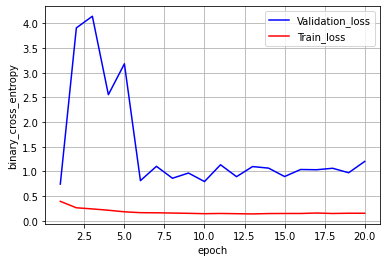

In [61]:
score=model.evaluate(x_test,y_test,verbose=0)
print('Test_score',score[0])
print('Test_accuracy',score[1])

fig,ax=plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('binary_cross_entropy')

x=list(range(1,20+1))
vy=history.history['val_loss']
ty=history.history['loss']
plt_dynamic(x,vy,ty,ax)

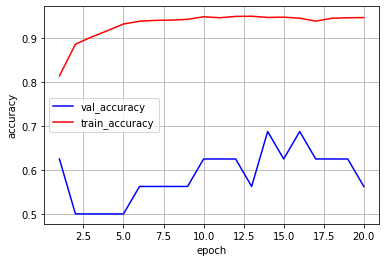

In [62]:
fig,ax=plt.subplots(1,1)
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')

x=list(range(1,20+1))
ty=history.history['accuracy']
vy=history.history['val_accuracy']
plt_dynamic(x,vy,ty,ax,label2='train_accuracy',label1='val_accuracy')

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

In [63]:
prediction=model.predict_classes(x_test)
cm=confusion_matrix(y_test,prediction)
print(cm)
print(classification_report(y_test, prediction, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

[[172  62]
 [  6 384]]
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.97      0.74      0.83       234
   Normal (Class 1)       0.86      0.98      0.92       390

           accuracy                           0.89       624
          macro avg       0.91      0.86      0.88       624
       weighted avg       0.90      0.89      0.89       624



In [ ]:
prediction=model.predict_classes(x_cv)

print(prediction.shape)


In [ ]:
import numpy as np
from sklearn.manifold import TSNE
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('../input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg',0)

# Initiate STAR detector
star = cv2.STAR_create()

# Initiate BRIEF extractor
brief = cv2.BRIEF_create()

# find the keypoints with STAR
kp = star.detect(img,None)

# compute the descriptors with BRIEF
kp, des = brief.compute(img, kp)

print (brief.getInt('bytes'))
print (des.shape)